In [25]:
!pip install tokenizers datasets transformers evaluation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for evaluation: filename=evaluation-0.0.2-py3-none-any.whl size=2447 sha256=3764f66f9635ae898ba906feb76a58e8cec561f9bd0251bdf4a3537f3e8ad6ee
  Stored in directory: /root/.cache/pip/wheels/3d/f1/f4/6c643c9c66223d853b8525812f17ec2cf02bf665b0c16a043a
  Created wheel for python-gflags: filename=python_gflags-3.1.2-py3-none-any.whl size=57370 sha256=154508bccceac55754f99ad1c3bcfa09b41446bb3853a02c75e75d64a1b97ba1

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import copy
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/CS521/"

Mounted at /content/drive


In [3]:
combined_dataset_train = torch.load(save_dir + 'combined_dataset_train.pt')
combined_dataset_test = torch.load(save_dir + 'combined_dataset_test.pt')


train_loader = DataLoader(dataset=combined_dataset_train,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=combined_dataset_test,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)

In [4]:
def load_model (model, save_dir,save_name ='best_model_s.pth'):
    model.load_state_dict(torch.load(os.path.join(save_dir,save_name)))
    model.eval()

    print('model loaded from {}'.format(os.path.join(save_dir,save_name)))
    return model

In [5]:
def print_model_size(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,'Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [6]:
class Student(nn.Module):
    def __init__(self, input_size, output_size):
        super(Student, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 5),
            nn.ReLU(inplace=True),
            nn.Linear(5, output_size),
            #nn.Softmax(dim=1)
        )
        # self.ff = nn.quantized.FloatFunctional()

    def forward(self, x):
        x = self.quant(x)
        # out = self.linear_relu_stack[0](x)
        logits= self.linear_relu_stack(x)
        # logits = self.ff.add(out, logits)


        return self.dequant(logits)

    def quantize(self, calibration_data):

        self.qconfig = torch.quantization.QConfig( activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8, quant_min=0, quant_max=255),
weight=torch.quantization.default_weight_observer)
        torch.quantization.fuse_modules(self, [['linear_relu_stack.0', 'linear_relu_stack.1']], inplace=True)
        self = torch.quantization.prepare(self)
        for data, target in calibration_data:
            self(data)
        self = torch.quantization.convert(self)

        return self


In [7]:
def check_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Assume test_loader is your test data loader

def calculate_model_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_kb = (param_size + buffer_size) / 1024
  print('model size: {:.3f}KB'.format(size_all_kb))

In [8]:
model = Student(384, 5)
model_copy= copy.deepcopy(model)
pre_trained_model = load_model(model_copy, save_dir)

model loaded from /content/drive/MyDrive/CS521/best_model_s.pth


In [9]:
# quantized_model
quantized_model = pre_trained_model.quantize(test_loader)

In [10]:
#calculate_model_size(quantized_model)
calculate_model_size(quantized_model)

model size: 0.012KB


In [11]:
for name, param in quantized_model.named_parameters():
    # if 'weight' in name:  # Check if this parameter is a weight
    print(name, "\t", param.data)

In [12]:
for param_tensor in quantized_model.state_dict():
    print(param_tensor, "\t", quantized_model.state_dict()[param_tensor])

quant.scale 	 tensor([0.0021])
quant.zero_point 	 tensor([117])
linear_relu_stack.0.scale 	 tensor(0.0266)
linear_relu_stack.0.zero_point 	 tensor(0)
linear_relu_stack.0._packed_params.dtype 	 torch.qint8
linear_relu_stack.0._packed_params._packed_params 	 (tensor([[-1.4956,  0.4712,  0.4098,  ...,  0.4507, -0.3893,  0.1434],
        [-0.0410, -0.7785,  0.6351,  ...,  0.9424, -1.2293,  0.2868],
        [ 1.1063, -0.3278,  0.1639,  ..., -1.0039, -0.1639,  0.3483],
        [ 0.7785,  0.4507, -0.2049,  ..., -0.8605, -0.1639,  0.6556],
        [-0.2663,  0.8810,  0.6146,  ..., -0.2663,  0.7581, -0.8605]],
       size=(5, 384), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.02048792876303196,
       zero_point=0), Parameter containing:
tensor([-0.0119,  0.3652,  0.6171,  0.8564,  0.3267], requires_grad=True))
linear_relu_stack.2.scale 	 tensor(0.1576)
linear_relu_stack.2.zero_point 	 tensor(146)
linear_relu_stack.2._packed_params.dtype 	 torch.qint8
linear_re

In [ ]:
# DISTILLED STUDENT

In [13]:
class Student(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Student, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 5),
            nn.ReLU(),

            nn.Linear(5, output_size),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

student_model = Student(384, 5)
student_model.load_state_dict(torch.load('/content/drive/MyDrive/CS521/best_model_s.pth'))
calculate_model_size(student_model)

model size: 7.637KB


In [14]:
for param_tensor in student_model.state_dict():
    print(param_tensor, "\t", student_model.state_dict()[param_tensor])

linear_relu_stack.0.weight 	 tensor([[-1.4908,  0.4760,  0.4041,  ...,  0.4502, -0.3865,  0.1450],
        [-0.0482, -0.7722,  0.6384,  ...,  0.9380, -1.2227,  0.2880],
        [ 1.1132, -0.3321,  0.1655,  ..., -1.0060, -0.1564,  0.3580],
        [ 0.7713,  0.4593, -0.2035,  ..., -0.8537, -0.1602,  0.6516],
        [-0.2646,  0.8905,  0.6092,  ..., -0.2608,  0.7620, -0.8635]])
linear_relu_stack.0.bias 	 tensor([-0.0119,  0.3652,  0.6171,  0.8564,  0.3267])
linear_relu_stack.2.weight 	 tensor([[-1.8212, -2.5322,  1.1615,  1.4682, -0.6332],
        [-2.2167,  0.5586,  1.0843,  0.1217, -1.5560],
        [-0.2809,  1.3239, -0.8585, -0.3531, -2.8051],
        [ 1.4518,  0.4491, -1.0931, -1.5399, -0.7299],
        [ 0.6347, -0.4679, -1.6671, -1.9192,  2.9489]])
linear_relu_stack.2.bias 	 tensor([ 0.3075, -0.4001,  0.1374,  0.1515,  0.0340])


In [ ]:
#PARENT MODEL

In [15]:
class Parent(torch.nn.Module):
    def __init__(self,input_size, output_size ):
        super(Parent, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),

            nn.Linear(100, output_size),
            nn.Softmax()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

parent_model = Parent(384, 5)
parent_model.load_state_dict(torch.load('/content/drive/MyDrive/CS521/best_model.pth'))
calculate_model_size(parent_model)

model size: 191.816KB


In [ ]:
calculate_model_size(parent_model)

model size: 191.816KB


In [16]:
def quantize(self, calibration_data):

  self.qconfig = torch.quantization.QConfig( activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8, quant_min=0, quant_max=255),
                                            weight=torch.quantization.default_weight_observer)
  torch.quantization.fuse_modules(self, [['linear_relu_stack.0', 'linear_relu_stack.1']], inplace=True)
  self = torch.quantization.prepare(self)
  for data, target in calibration_data:
      self(data)
  self = torch.quantization.convert(self)

In [17]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0
    batches = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (features, labels) in it_test:
      batches += 64
      #labels, input_ids, token_type_ids, attention_mask = data['label'], data['input_ids'], data['token_type_ids'], data['attention_mask']

      #labels, input_ids = labels.to(device), input_ids.to(device)

      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
       output = model(features) # do not compute gradient when performing prediction
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
    print('batches', batches)
    return mean_accuracy, test_loss

In [18]:
%%time
# parent accuracy
test_accuracy, test_loss= test(train_loader, parent_model, torch.nn.CrossEntropyLoss())
print(f"Validation accuracy is {str(test_accuracy)} \n")

Validating ...:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Validating ...: 100%|██████████| 782/782 [00:02<00:00, 266.22it/s]

Mean Accuracy: 0.5631
Avg loss: 1.3367010287921448
batches 50048
Validation accuracy is 0.56314 

CPU times: user 1.33 s, sys: 338 ms, total: 1.67 s
Wall time: 3 s


In [19]:
%%time
# distilled student accuracy
test_accuracy, test_loss= test(train_loader, student_model, torch.nn.CrossEntropyLoss())
print(f"Validation accuracy is {str(test_accuracy)} \n")

Validating ...: 100%|██████████| 782/782 [00:03<00:00, 238.57it/s]

Mean Accuracy: 0.5421
Avg loss: 1.3562061838481738
batches 50048
Validation accuracy is 0.54214 

CPU times: user 1.15 s, sys: 360 ms, total: 1.51 s
Wall time: 3.33 s


In [30]:
%%time
# quantized distilled student accuracy
test_accuracy, test_loss= test(train_loader, quantized_model, torch.nn.CrossEntropyLoss())
print(f"Validation accuracy is {str(test_accuracy)} \n")

Validating ...: 100%|██████████| 782/782 [00:02<00:00, 295.60it/s]

Mean Accuracy: 0.5419
Avg loss: 1.6157776003755877
batches 50048
Validation accuracy is 0.54192 

CPU times: user 1.15 s, sys: 354 ms, total: 1.5 s
Wall time: 2.7 s


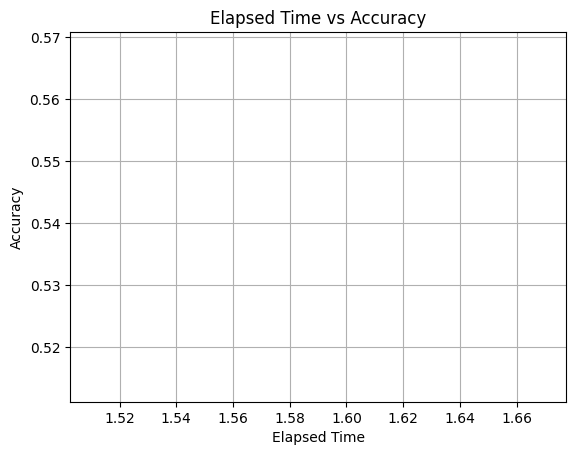

In [33]:
elapsed_times = [1.59]  # replace with your actual data
accuracies = [0.541]  # replace with your actual data

plt.plot(elapsed_times, accuracies,color='red')
plt.xlabel('Elapsed Time')
plt.ylabel('Accuracy')
plt.title('Elapsed Time vs Accuracy')
plt.grid(True)
plt.show()

In [21]:
def compute_mem_usage(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  return size_all_mb

In [22]:
def time_pipeline(self, query="What is the pin number for my account?"):
  """This overrides the PerformanceBenchmark.time_pipeline() method"""
  latencies = []
  # Warmup
  for _ in range(10):
    _ = self.pipeline(query)
    # Timed run
  for _ in range(100):
    start_time = perf_counter()
    _ = self.pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)
  # Compute run statistics
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = 1000 * np.std(latencies)
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

In [23]:
def compute_metrics(pred):
 predictions, labels = pred
 predictions = np.argmax(predictions, axis=1)
 return accuracy_score.compute(predictions=predictions, references=labels)

In [24]:
def get_pipeline(model,tokenizer=tokenizer,device=device):
  tokenize_kwargs = {"max_length":512,"truncation":True}
  return pipeline('text-classification',model=model,tokenizer=tokenizer,device=device,**tokenize_kwargs)

def compute_accuracy(pipeline):
 preds, labels = [], []
 label_encoder = dataset.features["label"].str2int
 for example in tqdm(dataset):
  pred = pipeline(example["text"])[0]["label"]
  label = example["label"]
  preds.append(label_encoder(pred))
  labels.append(label)
 accuracy = accuracy_score.compute(predictions=preds, references=labels)
 return accuracy['accuracy']

NameError: name 'tokenizer' is not defined

In [ ]:
start_time = time.time()
accuracy = check_accuracy(pre_trained_model,test_loader)
original_time = time.time() - start_time
print(f"Original model accuracy: {accuracy}%, inference time: {original_time}s")

Original model accuracy: 51.38%, inference time: 1.115506649017334s


In [ ]:
quantized_model_eval = load_model(quantized_model, save_dir,save_name='quantized_model.pth')
# quantized_model_eval.eval()
start_time = time.time()
accuracy = check_accuracy(quantized_model_eval,test_loader)
quantized_time = time.time() - start_time
print(f"Quantized model accuracy: {accuracy}%, inference time: {quantized_time}s")

model loaded from /content/drive/MyDrive/CS521/quantized_model.pth


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:383: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


Quantized model accuracy: 51.36%, inference time: 1.028329610824585s


In [ ]:
original_model_dtype = next(pre_trained_model.parameters()).dtype
print(f"Data type of original model: {original_model_dtype}")



Data type of original model: torch.float32


In [ ]:
# Get data type of quantized model
parameters = list(quantized_model.parameters())
if parameters:
    quantized_model_dtype = parameters[0].dtype
    print(f"Data type of quantized model: {quantized_model_dtype}")
else:
    print("The model has no parameters.")

The model has no parameters.
